# Cell interaction with CellPhoneDB

CellPhoneDB is a publicly available repository of curated receptors, ligands and their interactions in HUMAN. CellPhoneDB can be used to search for a particular ligand/receptor, or interrogate your own single-cell transcriptomics data. 

We made three improvements in integrating the CellPhoneDB algorithm in OmicVerse:

- We have added a tutorial on analysing `anndata` based on any `anndata`.
- We added prettier heatmaps, chord diagrams and network diagrams for visualising relationships between cells.
- We added visualisation of ligand receptor proteins in different groups

Paper: [Single-cell reconstruction of the early maternal–fetal interface in humans](https://www.nature.com/articles/s41586-018-0698-6)

Code: https://github.com/ventolab/CellphoneDB

This notebook will demonstrate how to use CellPhoneDB on scRNA data and visualize it.

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import omicverse as ov
import os

ov.plot_set()
#print(f'cellphonedb version{cellphonedb.__version__}')


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.3, Tutorials: https://omicverse.readthedocs.io/


## The EVT Data

Th EVT data have finished the celltype annotation, it can be download from the tutorial of CellPhoneDB.

Download: https://github.com/ventolab/CellphoneDB/blob/master/notebooks/data_tutorial.zip


In [2]:
adata=sc.read('data/cpdb/normalised_log_counts.h5ad')
adata=adata[adata.obs['cell_labels'].isin(['eEVT','iEVT','EVT_1','EVT_2','DC','dNK1','dNK2','dNK3',
                                          'VCT','VCT_CCC','VCT_fusing','VCT_p','GC','SCT'])]
adata

View of AnnData object with n_obs × n_vars = 1065 × 30800
    obs: 'n_genes', 'n_counts', 'cell_labels'
    var: 'gene_ids', 'feature_types'
    uns: 'neighbors_scVI_n_latent_14_sample_n_layers_3', 'neighbors_scVI_n_latent_20_sample_n_layers_3', 'umap'
    obsm: 'X_scVI_n_latent_14_sample_n_layers_3', 'X_scVI_n_latent_20_sample_n_layers_3', 'X_umap', 'X_umap_scVI_n_latent_14_sample_n_layers_3', 'X_umap_scVI_n_latent_20_sample_n_layers_3'
    obsp: 'neighbors_scVI_n_latent_14_sample_n_layers_3_connectivities', 'neighbors_scVI_n_latent_14_sample_n_layers_3_distances', 'neighbors_scVI_n_latent_20_sample_n_layers_3_connectivities', 'neighbors_scVI_n_latent_20_sample_n_layers_3_distances'

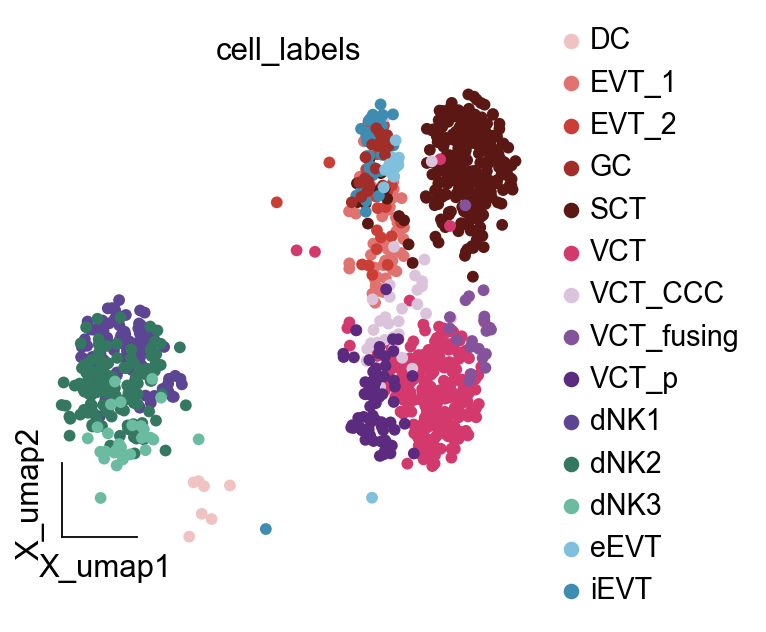

In [3]:
ov.pl.embedding(adata,
               basis='X_umap',
               color='cell_labels',
               frameon='small',
               palette=ov.pl.red_color+ov.pl.blue_color+ov.pl.green_color+ov.pl.orange_color+ov.pl.purple_color)

In [4]:
adata.X.max()

7.124379

We can clearly see that the maximum value of the data is a floating point number less than 10. The fact that the maximum value is not an integer means that it has been normalised, and the fact that it is less than 10 means that it has been logarithmised. Note that our data cannot be `scaled`.

## Export the anndata object

As the input to CellPhoneDB only requires the expression matrix and cell type, we extracted only the expression matrix and cell type from adata for the next step of analysis

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata1=sc.AnnData(adata.X,obs=pd.DataFrame(index=adata.obs.index),
                          var=pd.DataFrame(index=adata.var.index))
adata1.write_h5ad('data/cpdb/norm_log.h5ad',compression='gzip')
adata1

filtered out 11158 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 1065 × 19642

## Export the meta info of cells

we construct a `DataFrame` object to export the meta info of cells. In EVT adata object, the celltypes were stored in the `obs['cell_labels']`

In [7]:
#meta导出
df_meta = pd.DataFrame(data={'Cell':list(adata[adata1.obs.index].obs.index),
                             'cell_type':[ i for i in adata[adata1.obs.index].obs['cell_labels']]
                            })
df_meta.set_index('Cell', inplace=True)
df_meta.to_csv('data/cpdb/meta.tsv', sep = '\t')

## Cell interaction analysis

Now, we prepare the meta info of cells `meta.tsv` and matrix of scRNA-eq `norm_log.h5ad`, we can use the method of CellPhoneDB to calculate the interaction of each celltype in scRNA-seq data. 

Importantly, to avoid a series of bugs, we set the absolute path for CellPhoneDB analysis. we use `os.getcwd() ` to get the path now analysis.

In [8]:
import os
os.getcwd() 

'/mnt/home/zehuazeng/analysis/ov_nocd'

Another thing to note is that we need to download the `cellphonedb.zip` file from `cellphonedb-data` for further analysis. I have placed it in the `data/CPDB` directory, but you can place it in any path you are interested in

Downloads: https://github.com/ventolab/cellphonedb-data

In [9]:
cpdb_file_path = '/mnt/home/zehuazeng/data/cellphonedb/cellphonedb.zip'
meta_file_path = os.getcwd()+'/data/cpdb/meta.tsv'
counts_file_path = os.getcwd()+'/data/cpdb/norm_log.h5ad'
microenvs_file_path = None
active_tf_path = None
out_path =os.getcwd()+'/data/cpdb/test_cellphone'

Now we run `cpdb_statistical_analysis_method` to predicted the cell interaction in scRNA-seq

In [10]:
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

cpdb_results = cpdb_statistical_analysis_method.call(
    cpdb_file_path = cpdb_file_path,                 # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,                 # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,             # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    counts_data = 'hgnc_symbol',                     # defines the gene annotation in counts matrix.
    active_tfs_file_path = active_tf_path,           # optional: defines cell types and their active TFs.
    microenvs_file_path = microenvs_file_path,       # optional (default: None): defines cells per microenvironment.
    score_interactions = True,                       # optional: whether to score interactions or not. 
    iterations = 1000,                               # denotes the number of shufflings performed in the analysis.
    threshold = 0.1,                                 # defines the min % of cells expressing a gene for this to be employed in the analysis.
    threads = 10,                                     # number of threads to use in the analysis.
    debug_seed = 42,                                 # debug randome seed. To disable >=0.
    result_precision = 3,                            # Sets the rounding for the mean values in significan_means.
    pvalue = 0.05,                                   # P-value threshold to employ for significance.
    subsampling = False,                             # To enable subsampling the data (geometri sketching).
    subsampling_log = False,                         # (mandatory) enable subsampling log1p for non log-transformed data inputs.
    subsampling_num_pc = 100,                        # Number of componets to subsample via geometric skectching (dafault: 100).
    subsampling_num_cells = 1000,                    # Number of cells to subsample (integer) (default: 1/3 of the dataset).
    separator = '|',                                 # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    debug = False,                                   # Saves all intermediate tables employed during the analysis in pkl format.
    output_path = out_path,                          # Path to save results.
    output_suffix = None                             # Replaces the timestamp in the output files by a user defined string in the  (default: None).
    )

Reading user files...
The following user files were loaded successfully:
/mnt/home/zehuazeng/analysis/ov_nocd/data/cpdb/norm_log.h5ad
/mnt/home/zehuazeng/analysis/ov_nocd/data/cpdb/meta.tsv
[ ][CORE][27/06/24-22:52:47][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:42 Threads:10 Precision:3
[ ][CORE][27/06/24-22:52:47][WARNING] Debug random seed enabled. Set to 42
[ ][CORE][27/06/24-22:52:48][INFO] Running Real Analysis
[ ][CORE][27/06/24-22:52:48][INFO] Running Statistical Analysis


100%|██████████| 1000/1000 [00:06<00:00, 157.70it/s]

[ ][CORE][27/06/24-22:52:55][INFO] Building Pvalues result


[ ][CORE][27/06/24-22:52:55][INFO] Building results
[ ][CORE][27/06/24-22:52:55][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 14/14 [00:00<00:00, 506.54it/s]

[ ][CORE][27/06/24-22:52:55][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 14/14 [00:00<00:00, 1361.50it/s]


[ ][CORE][27/06/24-22:52:55][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 196/196 [00:20<00:00,  9.50it/s]


Saved deconvoluted to /mnt/home/zehuazeng/analysis/ov_nocd/data/cpdb/test_cellphone/statistical_analysis_deconvoluted_06_27_2024_225317.txt
Saved deconvoluted_percents to /mnt/home/zehuazeng/analysis/ov_nocd/data/cpdb/test_cellphone/statistical_analysis_deconvoluted_percents_06_27_2024_225317.txt
Saved means to /mnt/home/zehuazeng/analysis/ov_nocd/data/cpdb/test_cellphone/statistical_analysis_means_06_27_2024_225317.txt
Saved pvalues to /mnt/home/zehuazeng/analysis/ov_nocd/data/cpdb/test_cellphone/statistical_analysis_pvalues_06_27_2024_225317.txt
Saved significant_means to /mnt/home/zehuazeng/analysis/ov_nocd/data/cpdb/test_cellphone/statistical_analysis_significant_means_06_27_2024_225317.txt
Saved interaction_scores to /mnt/home/zehuazeng/analysis/ov_nocd/data/cpdb/test_cellphone/statistical_analysis_interaction_scores_06_27_2024_225317.txt


In [11]:
ov.utils.save(cpdb_results,'data/cpdb/gex_cpdb_test.pkl')

In [5]:
cpdb_results=ov.utils.load('data/cpdb/gex_cpdb_test.pkl')

## Network of celltype analysis

It is worth noting that we will be using ov for all downstream analysis, starting with cell network analysis, where we provide the `ov.single.cpdb_network_cal` function to extract interactions, and the `ov.single.cpdb_plot_network` function for very elegant visualization

In [12]:
interaction=ov.single.cpdb_network_cal(adata = adata,
        pvals = cpdb_results['pvalues'],
        celltype_key = "cell_labels",)   

ktplotspy have been install version: 0.2.3


In [13]:
interaction['interaction_edges'].head()

,SOURCE,TARGET,COUNT
0,DC,DC,62
1,DC,EVT_1,34
2,DC,EVT_2,36
3,DC,GC,43
4,DC,SCT,22


In [19]:
ov.plot_set()

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 214.54843843872115
Plotting legends..
Estimated legend width: 14.465277777777779 mm


<Axes: ylabel='COUNT'>

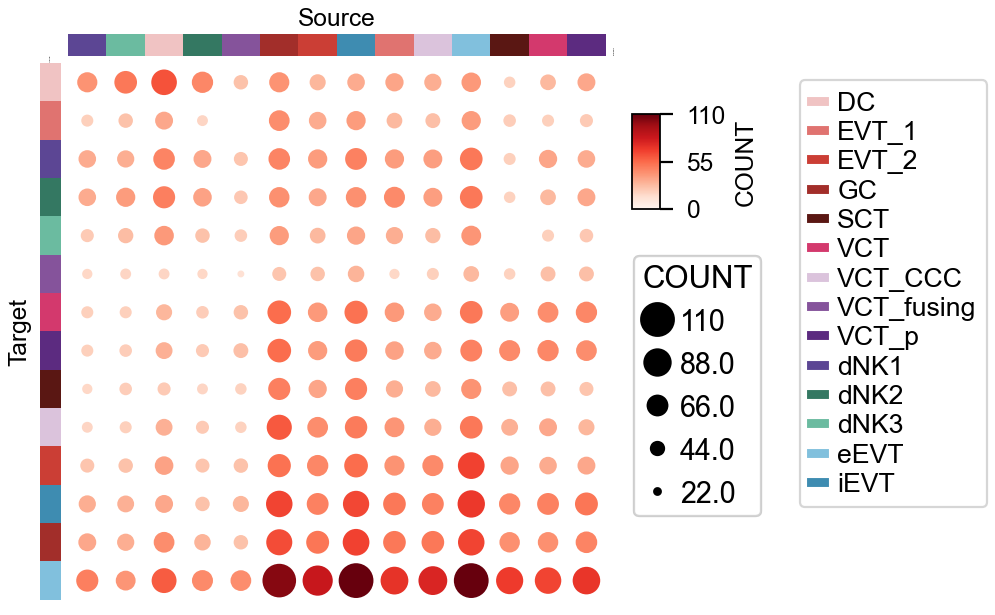

In [23]:
fig, ax = plt.subplots(figsize=(4,4)) 
ov.pl.cpdb_heatmap(adata,interaction['interaction_edges'],celltype_key='cell_labels',
                   fontsize=11,
          ax=ax,legend_kws={'fontsize':12,'bbox_to_anchor':(5, -0.9),'loc':'center left',})

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 214.54843843872115
Plotting legends..
Estimated legend width: 14.465277777777779 mm


<Axes: ylabel='COUNT'>

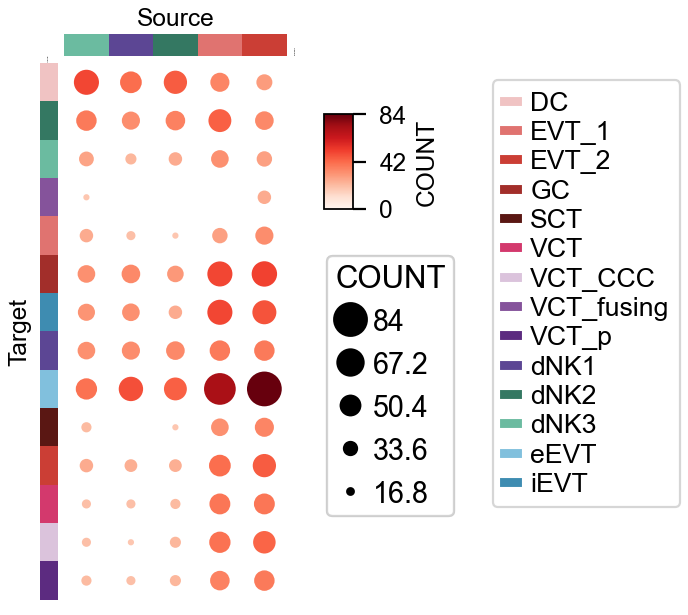

In [24]:
fig, ax = plt.subplots(figsize=(2,4)) 
ov.pl.cpdb_heatmap(adata,interaction['interaction_edges'],celltype_key='cell_labels',
                   source_cells=['EVT_1','EVT_2','dNK1','dNK2','dNK3'],
          ax=ax,legend_kws={'fontsize':12,'bbox_to_anchor':(5, -0.9),'loc':'center left',})

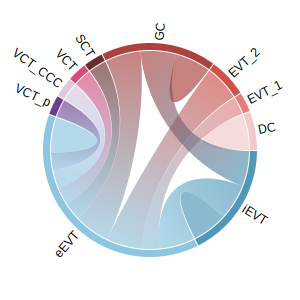

In [28]:
fig=ov.pl.cpdb_chord(adata,interaction['interaction_edges'],celltype_key='cell_labels',
          count_min=60,fontsize=12,padding=50,radius=100,save=None,)
fig.show()

<AxesSubplot: >

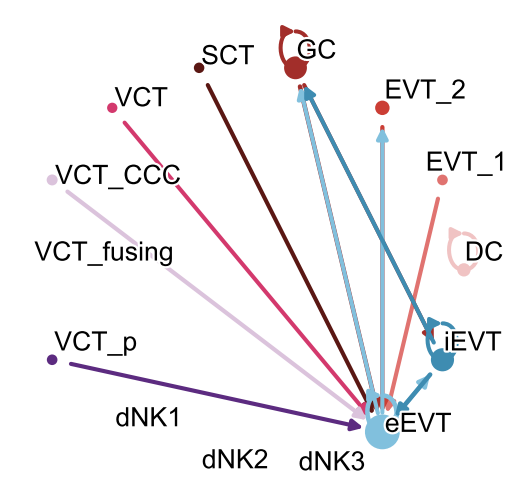

In [29]:
fig, ax = plt.subplots(figsize=(4,4)) 
ov.pl.cpdb_network(adata,interaction['interaction_edges'],celltype_key='cell_labels',
             counts_min=60,
            nodesize_scale=5,
                  ax=ax)

<AxesSubplot: >

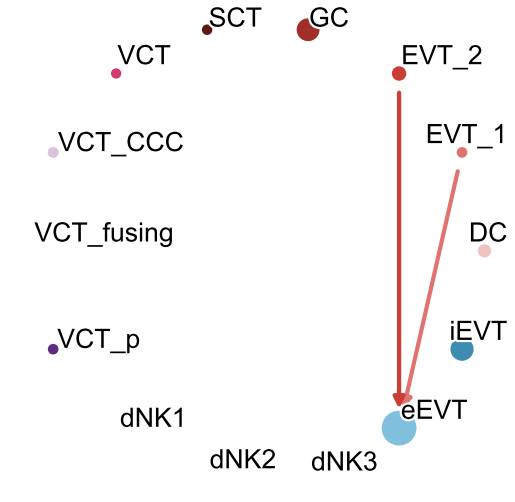

In [30]:
fig, ax = plt.subplots(figsize=(4,4)) 
ov.pl.cpdb_network(adata,interaction['interaction_edges'],celltype_key='cell_labels',
            counts_min=60,
            nodesize_scale=5,
            source_cells=['EVT_1','EVT_2','dNK1','dNK2','dNK3'],
            ax=ax)

<AxesSubplot: >

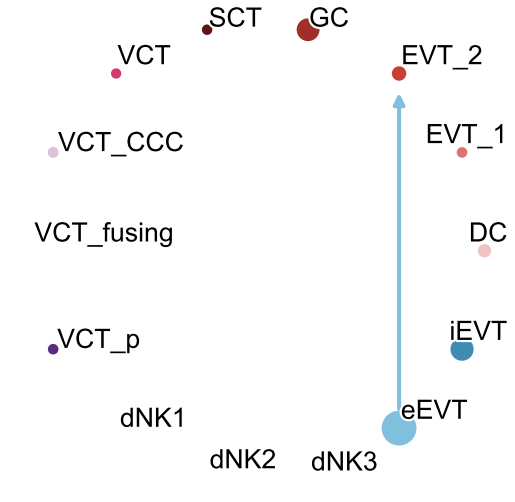

In [31]:
fig, ax = plt.subplots(figsize=(4,4)) 
ov.pl.cpdb_network(adata,interaction['interaction_edges'],celltype_key='cell_labels',
            counts_min=60,
            nodesize_scale=5,
            target_cells=['EVT_1','EVT_2','dNK1','dNK2','dNK3'],
            ax=ax)

ktplotspy have been install version: 0.2.3


<AxesSubplot: title={'center': 'EVT Network'}>

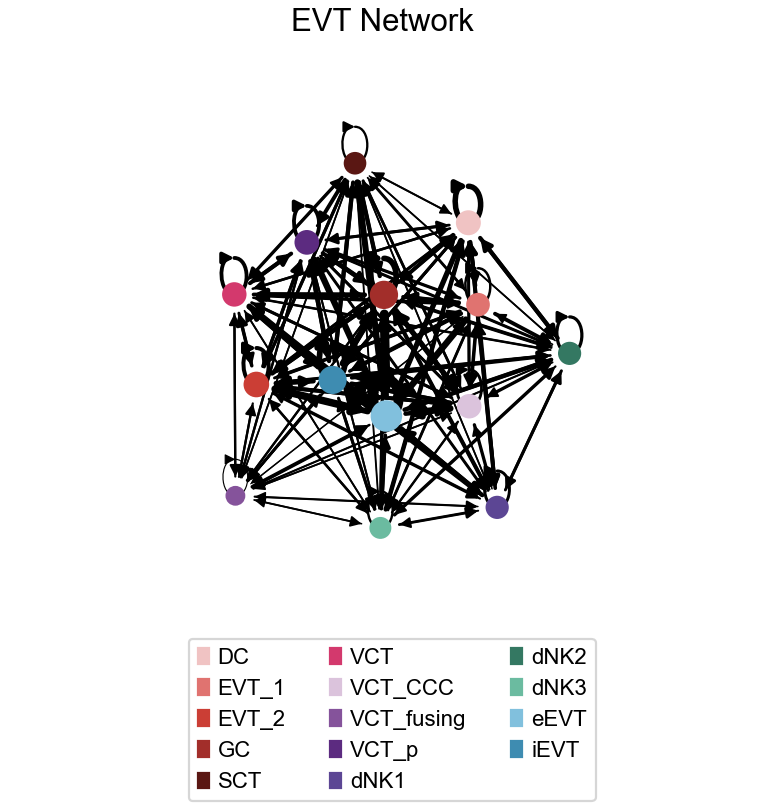

In [32]:
ov.single.cpdb_plot_network(adata=adata,
                  interaction_edges=interaction['interaction_edges'],
                  celltype_key='cell_labels',
                  nodecolor_dict=None,title='EVT Network',
                  edgeswidth_scale=25,nodesize_scale=10,
                  pos_scale=1,pos_size=10,figsize=(6,6),
                  legend_ncol=3,legend_bbox=(0.8,0.2),legend_fontsize=10)

Sometimes, the whole network you don't want to use for analysis, the sub-network is useful for analysis. we can exacted the sub-network from it.

We need to exacted the sub-interaction first, we assumed that the five celltypes `['EVT_1','EVT_2','dNK1','dNK2','dNK3']` which is interested

In [33]:
sub_i=interaction['interaction_edges']
sub_i=sub_i.loc[sub_i['SOURCE'].isin(['EVT_1','EVT_2','dNK1','dNK2','dNK3'])]
sub_i=sub_i.loc[sub_i['TARGET'].isin(['EVT_1','EVT_2','dNK1','dNK2','dNK3'])]

Then, we exacted the sub-anndata object

In [34]:
sub_adata=adata[adata.obs['cell_labels'].isin(['EVT_1','EVT_2','dNK1','dNK2','dNK3'])]
sub_adata

View of AnnData object with n_obs × n_vars = 336 × 19642
    obs: 'n_genes', 'n_counts', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'neighbors_scVI_n_latent_14_sample_n_layers_3', 'neighbors_scVI_n_latent_20_sample_n_layers_3', 'umap', 'cell_labels_colors'
    obsm: 'X_scVI_n_latent_14_sample_n_layers_3', 'X_scVI_n_latent_20_sample_n_layers_3', 'X_umap', 'X_umap_scVI_n_latent_14_sample_n_layers_3', 'X_umap_scVI_n_latent_20_sample_n_layers_3'
    obsp: 'neighbors_scVI_n_latent_14_sample_n_layers_3_connectivities', 'neighbors_scVI_n_latent_14_sample_n_layers_3_distances', 'neighbors_scVI_n_latent_20_sample_n_layers_3_connectivities', 'neighbors_scVI_n_latent_20_sample_n_layers_3_distances'

Now we plot the sub-interaction network between the cells in scRNA-seq

ktplotspy have been install version: 0.2.3


<AxesSubplot: title={'center': 'Sub-EVT Network'}>

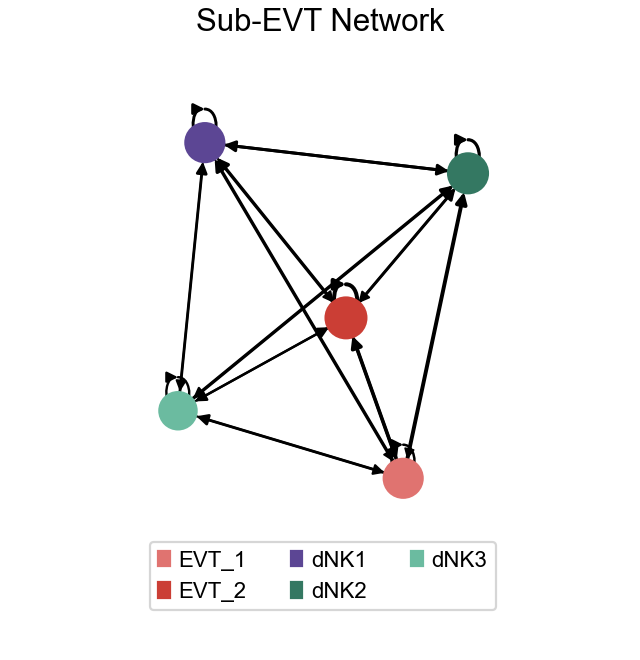

In [35]:
ov.single.cpdb_plot_network(adata=sub_adata,
                  interaction_edges=sub_i,
                  celltype_key='cell_labels',
                  nodecolor_dict=None,title='Sub-EVT Network',
                  edgeswidth_scale=25,nodesize_scale=1,
                  pos_scale=1,pos_size=10,figsize=(5,5),
                  legend_ncol=3,legend_bbox=(0.8,0.2),legend_fontsize=10)

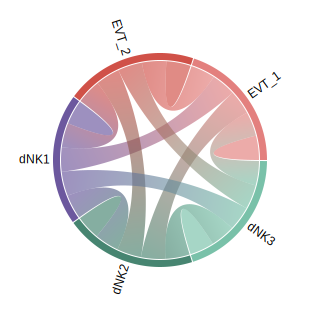

In [36]:
fig=ov.pl.cpdb_chord(sub_adata,sub_i,celltype_key='cell_labels',
          count_min=10,fontsize=12,padding=60,radius=100,save=None,)
fig.show()

<AxesSubplot: >

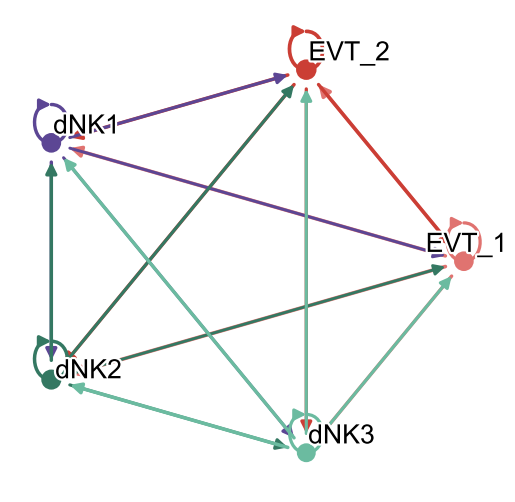

In [37]:
fig, ax = plt.subplots(figsize=(4,4)) 
ov.pl.cpdb_network(sub_adata,sub_i,celltype_key='cell_labels',
             counts_min=10,
            nodesize_scale=5,
                  ax=ax)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 905.5273389155578
Plotting legends..
Estimated legend width: 14.465277777777779 mm
Incresing ncol


<Axes: ylabel='COUNT'>

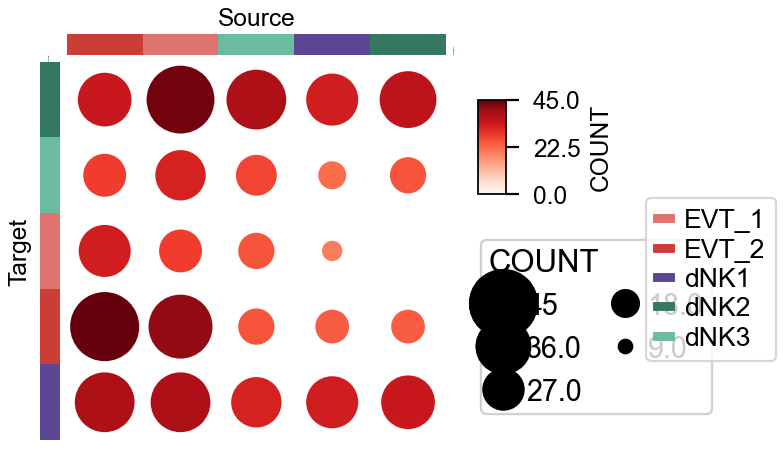

In [38]:
fig, ax = plt.subplots(figsize=(3,3)) 
ov.pl.cpdb_heatmap(sub_adata,sub_i,celltype_key='cell_labels',
          ax=ax,legend_kws={'fontsize':12,'bbox_to_anchor':(5, -0.9),'loc':'center left',})

## The ligand-receptor exacted

We can set EVT as ligand or receptor to exacted the ligand-receptor proteins from the result of CellPhoneDB.



The most important step is that we need to extract the results of the analysis with eEVT as the ligand, and here we use ov's function `ov.single.cpdb_exact_target`,`ov.single.cpdb_exact_source` to do this

In [5]:
sub_means=ov.single.cpdb_exact_target(cpdb_results['means'],['eEVT','iEVT'])
sub_means=ov.single.cpdb_exact_source(sub_means,['dNK1','dNK2','dNK3'])
sub_means.head() 

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,dNK1|eEVT,dNK1|iEVT,dNK2|eEVT,dNK2|iEVT,dNK3|eEVT,dNK3|iEVT
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,0.289,0.032,0.293,0.036,0.365,0.108
1,CPI-SC0B5CEA47D,COL10A1_integrin_a2b1_complex,simple:Q03692,complex:integrin_a2b1_complex,COL10A1,NaN,True,False,False,curated,0.000,0.000,0.000,0.000,0.000,0.000
2,CPI-SC0C8B7BCBB,COL11A1_integrin_a2b1_complex,simple:P12107,complex:integrin_a2b1_complex,COL11A1,NaN,True,False,False,curated,0.000,0.000,0.000,0.000,0.000,0.000
4,CPI-SC0B86B7CED,COL12A1_integrin_a2b1_complex,simple:Q99715,complex:integrin_a2b1_complex,COL12A1,NaN,True,False,False,curated,0.000,0.000,0.283,0.027,0.000,0.000
6,CPI-SC0CCCF9A7F,COL14A1_integrin_a2b1_complex,simple:Q05707,complex:integrin_a2b1_complex,COL14A1,NaN,True,False,False,curated,0.299,0.043,0.000,0.000,0.000,0.000


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 64.85664438493002
Plotting legends..
Estimated legend width: 21.344444444444445 mm


<Axes: ylabel='means'>

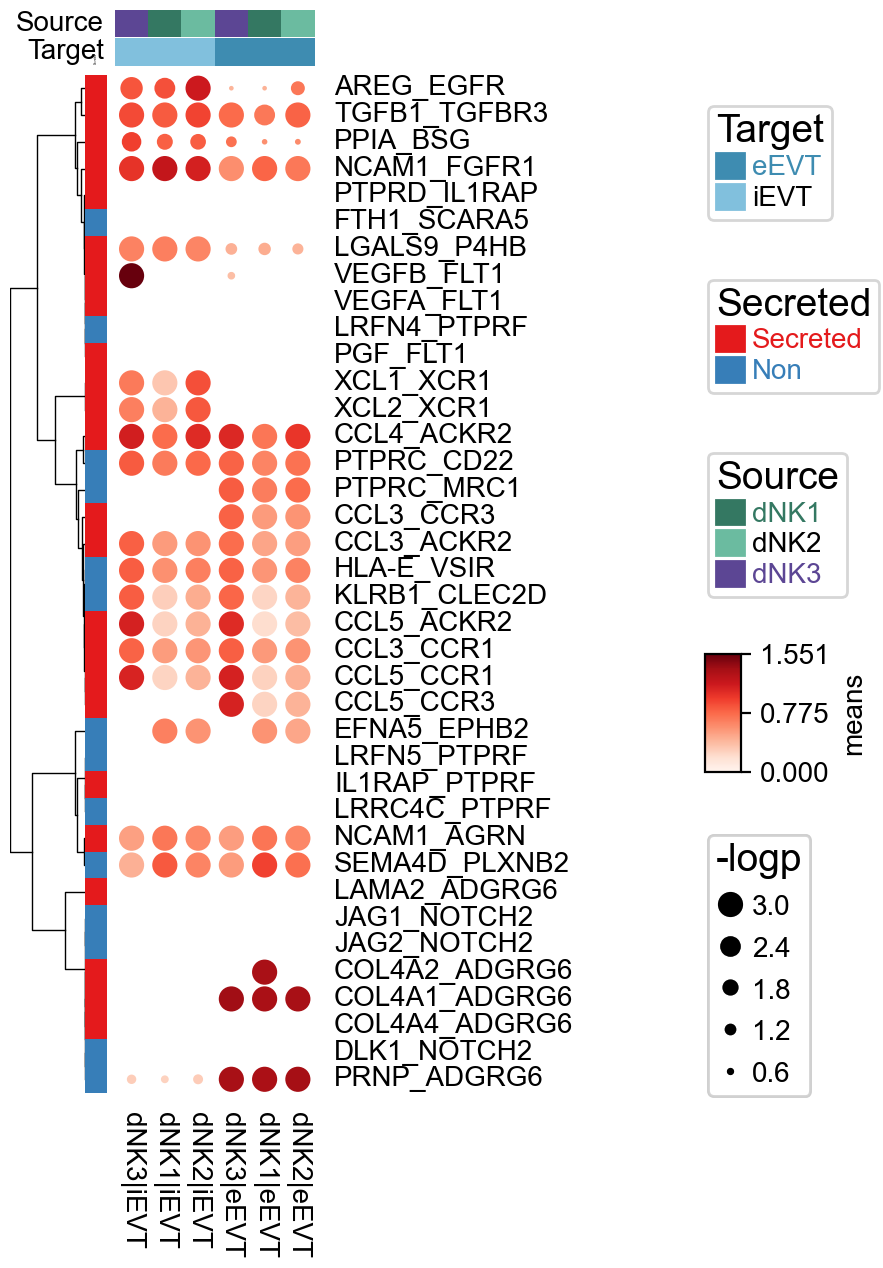

In [6]:
ov.pl.cpdb_interacting_heatmap(adata=adata,
                         celltype_key='cell_labels',
                            means=cpdb_results['means'],
                            pvalues=cpdb_results['pvalues'],
                            source_cells=['dNK1','dNK2','dNK3'],
                            target_cells=['eEVT','iEVT'],
                            plot_secret=True,
                            min_means=3,
                            nodecolor_dict=None,
                            ax=None,
                            figsize=(2,6),
                            fontsize=10,)

Sometimes we care about the expression of ligand in SOURCE and receptor in TARGET, we provide another function for getting the expression situation

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 68.44834404040272
Plotting legends..
Estimated legend width: 21.344444444444445 mm


<Axes: ylabel='Source'>

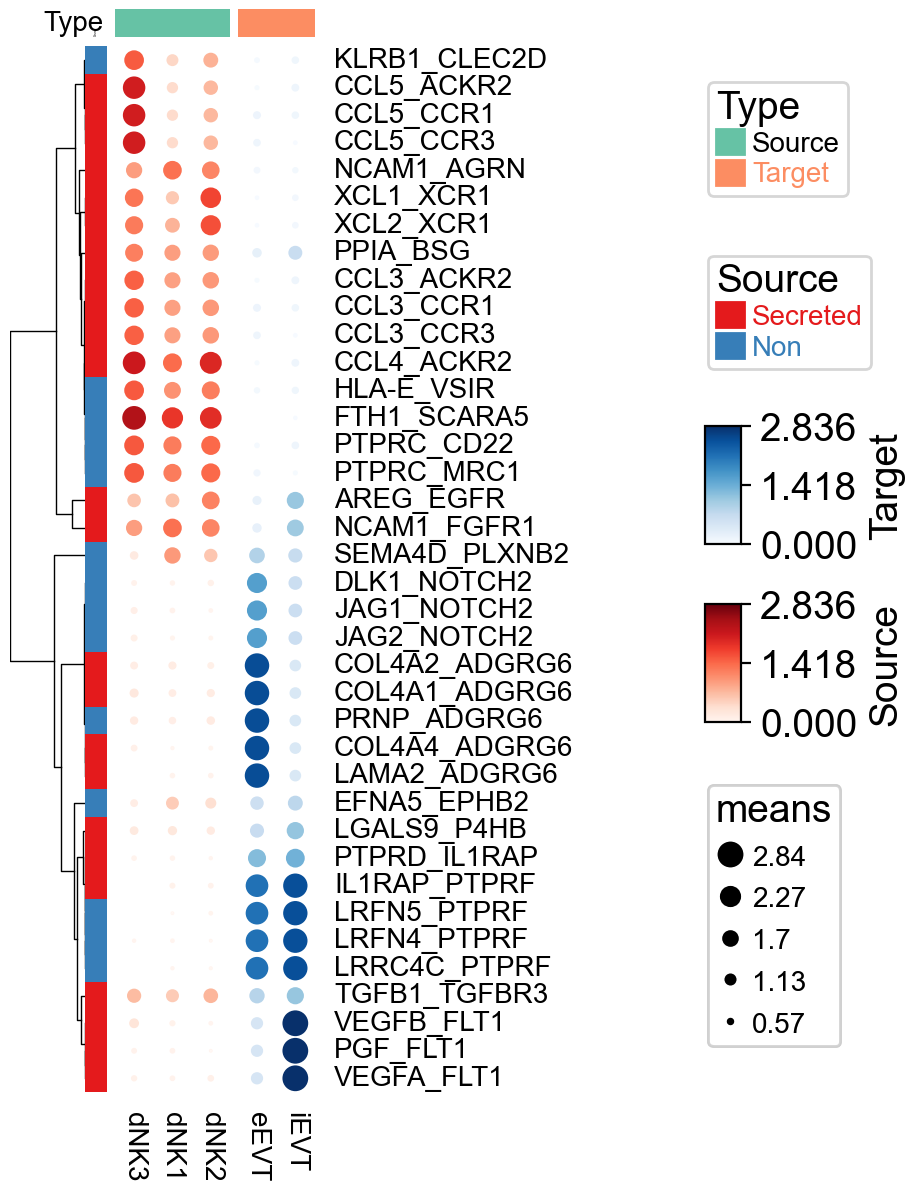

In [7]:
ov.pl.cpdb_group_heatmap(adata=adata,
                         celltype_key='cell_labels',
                            means=cpdb_results['means'],
                            cmap={'Target':'Blues','Source':'Reds'},
                            source_cells=['dNK1','dNK2','dNK3'],
                            target_cells=['eEVT','iEVT'],
                            plot_secret=True,
                            min_means=3,
                            nodecolor_dict=None,
                            ax=None,
                            figsize=(2,6),
                            fontsize=10,)

We can also build Ligand, Receptor, SOURCE, and TARGET into a regulatory network, which is interesting.

<AxesSubplot: >

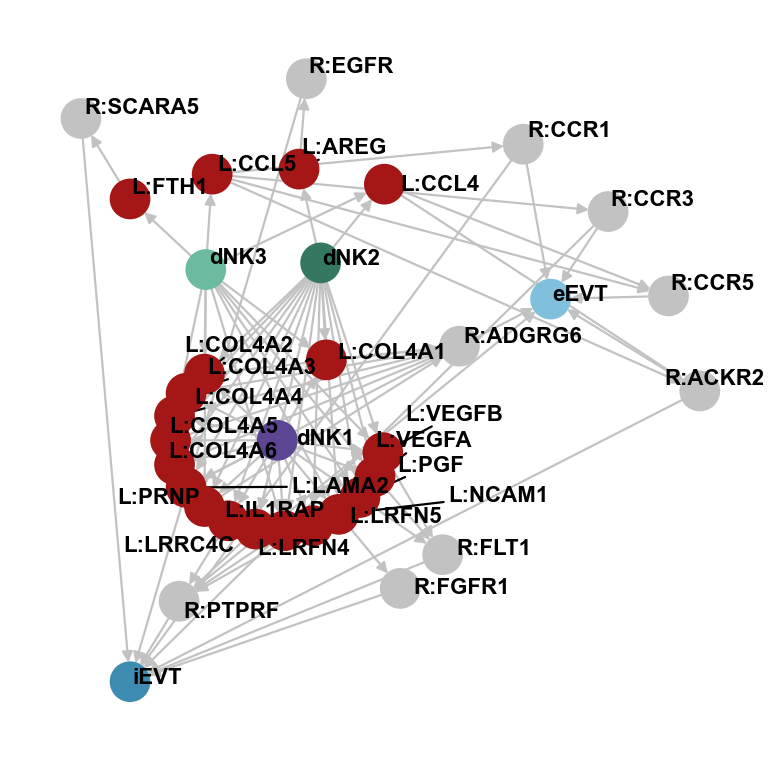

In [6]:
ov.pl.cpdb_interacting_network(adata=adata,
                         celltype_key='cell_labels',
                            means=cpdb_results['means'],
                            source_cells=['dNK1','dNK2','dNK3'],
                            target_cells=['eEVT','iEVT'],
                            means_min=1,
                             means_sum_min=1,        
                            nodecolor_dict=None,
                            ax=None,
                            figsize=(6,6),
                            fontsize=10)

Sometimes we want to analyse ligand-receptor pathway enrichment or function, so we need to extract ligand-receptor pairs from the significant ligand-receptors filtered out above, and omicverse provides an easy function `ov.single.cpdb_interaction_filtered` to do this here

In [10]:
sub_means=sub_means.loc[~sub_means['gene_a'].isnull()]
sub_means=sub_means.loc[~sub_means['gene_b'].isnull()]
enrichr_genes=sub_means['gene_a'].tolist()+sub_means['gene_b'].tolist()

A tutorial on enrichment you can find in the Bulk chapter of tutorials:

https://omicverse.readthedocs.io/en/latest/Tutorials-bulk/t_deg/ or https://starlitnightly.github.io/omicverse/Tutorials-bulk/t_deg/

In [12]:
pathway_dict=ov.utils.geneset_prepare('genesets/GO_Biological_Process_2023.txt',organism='Human')

In [14]:
#deg_genes=dds.result.loc[dds.result['sig']!='normal'].index.tolist()
enr=ov.bulk.geneset_enrichment(gene_list=enrichr_genes,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto',
                                organism='human')

<AxesSubplot: title={'center': 'GO-Bio(EVT)'}, xlabel='Fractions of genes'>

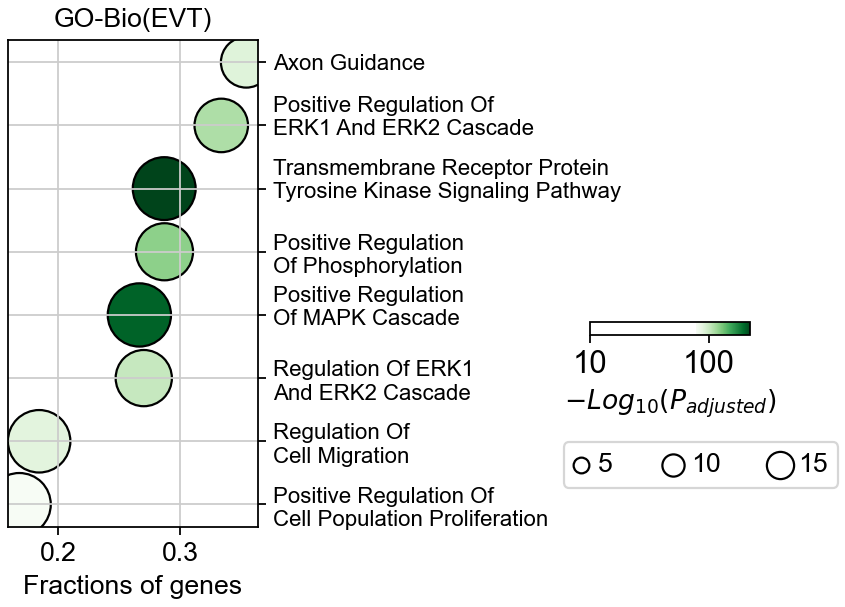

In [20]:
ov.plot_set()
ov.bulk.geneset_plot(enr,figsize=(2,4),fig_title='GO-Bio(EVT)',
                    cax_loc=[2, 0.45, 0.5, 0.02],num=8,
                    bbox_to_anchor_used=(-0.25, -13),custom_ticks=[10,100],
                    cmap='Greens')